## Pairs Trading

This is an introduction to pairs trading, while scraping data from the web

In [1]:
import numpy as np
np.random.seed(100) # ensure that random numbers stay the same, to ensure that the values are easily reproducible
import pandas as pd
import yfinance as yf


import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from statsmodels.regression.rolling import RollingOLS

from bs4 import BeautifulSoup
import requests as re
import html5lib

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = (12, 8)

In [2]:
def find_cointegrated_pairs(data: pd.DataFrame, val):
    """
    Takes the returns of all the stock (in our universe) and finds the cointegrated pairs
    """
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < val:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [3]:
def scrape_dow():
    URL = "https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average"

    r = re.get(URL)

    soup = BeautifulSoup(r.content, "lxml")

    table = soup.find('table', attrs = {'id':'constituents'})

    stocks = []

    for ticker in table.findAll("a", attrs = {"class":"external text"}):
        stocks.append(ticker.get_text())
    
    return stocks

In [4]:
stocks = scrape_dow()
stocks.append("^GSPC") # adding the s&p for backtesting

In [5]:
df = yf.download(stocks, start="2015-01-01")['Adj Close']
df.dropna(axis=1, inplace=True)
df.columns.values[-1] = "S&P500"
stocks[-1] = "S&P500"

train = df[:-252]
test = df[df.shape[0]-252:]

[*********************100%***********************]  31 of 31 completed


In [7]:
scores, pvals, pairs = find_cointegrated_pairs(train, 0.05)

In [8]:
pairs

[('AAPL', 'NKE'),
 ('AMGN', 'CRM'),
 ('AMGN', 'INTC'),
 ('AMGN', 'V'),
 ('AMGN', 'VZ'),
 ('AMGN', 'WBA'),
 ('AMGN', 'WMT'),
 ('AXP', 'JPM'),
 ('CRM', 'HD'),
 ('CRM', 'MSFT'),
 ('CRM', 'NKE'),
 ('CRM', 'UNH'),
 ('CRM', 'WMT'),
 ('DIS', 'HD'),
 ('DIS', 'NKE'),
 ('HD', 'MSFT'),
 ('HD', 'NKE'),
 ('HD', 'UNH'),
 ('HD', 'S&P500'),
 ('IBM', 'INTC'),
 ('IBM', 'JNJ'),
 ('IBM', 'JPM'),
 ('IBM', 'KO'),
 ('IBM', 'MCD'),
 ('IBM', 'MMM'),
 ('IBM', 'MRK'),
 ('IBM', 'MSFT'),
 ('IBM', 'NKE'),
 ('IBM', 'PG'),
 ('IBM', 'TRV'),
 ('IBM', 'UNH'),
 ('IBM', 'V'),
 ('IBM', 'VZ'),
 ('IBM', 'WBA'),
 ('IBM', 'WMT'),
 ('IBM', 'S&P500'),
 ('INTC', 'V'),
 ('INTC', 'VZ'),
 ('INTC', 'WBA'),
 ('JNJ', 'UNH'),
 ('KO', 'MCD'),
 ('KO', 'MRK'),
 ('KO', 'VZ'),
 ('KO', 'WBA'),
 ('KO', 'WMT'),
 ('MRK', 'VZ'),
 ('MSFT', 'NKE'),
 ('UNH', 'S&P500'),
 ('V', 'WMT'),
 ('VZ', 'WBA'),
 ('VZ', 'WMT'),
 ('WBA', 'WMT')]

In [9]:
df_rets = train.pct_change() + 1

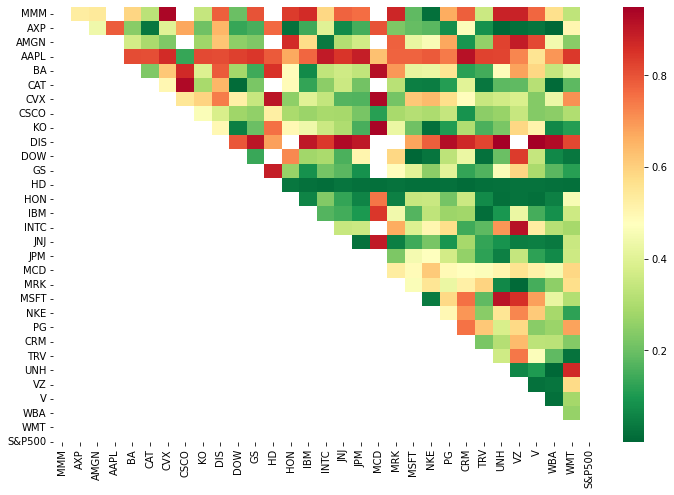

In [11]:
sns.heatmap(pvals, xticklabels=stocks, yticklabels=stocks, cmap="RdYlGn_r", mask = (pvals >= 0.95))
plt.show()

In [12]:
zscores = pd.DataFrame()
log_spreads = pd.DataFrame()

for pair in pairs:

    S1 = df[pair[0]]
    S2 = df[pair[1]]

    rolling_beta = RollingOLS(S1, S2, window=7)
    rres = rolling_beta.fit()
    rres.params.dropna(inplace=True)
    spread = np.log(S2) - rres.params[pair[1]] * np.log(S1)

    spread.name = 'spread'
    
    log_spreads[f"{pair[0]}-{pair[1]}"] = spread

    # Get the 1 day moving average of the price spread
    spread_mavg1 = spread.rolling(1).mean()
    spread_mavg1.name = 'spread 1d mavg'

    # Get the rolling moving average
    spread_mavg = spread.rolling(7).mean()
    spread_mavg.name = 'spread 5d mavg'
    
    std_ = spread.rolling(7).std()
    std_.name = 'std'

    # Compute the z score for each day
    zscore = (spread_mavg1 - spread_mavg)/std_
    zscore.name = 'z-score'
    
    zscores[f"{pair[0]}-{pair[1]}"] = zscore  

C:\Users\GivyBoy\AppData\Local\Temp/ipykernel_20732/3960358394.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1, ax2, ax3) = plt.subplots(3)


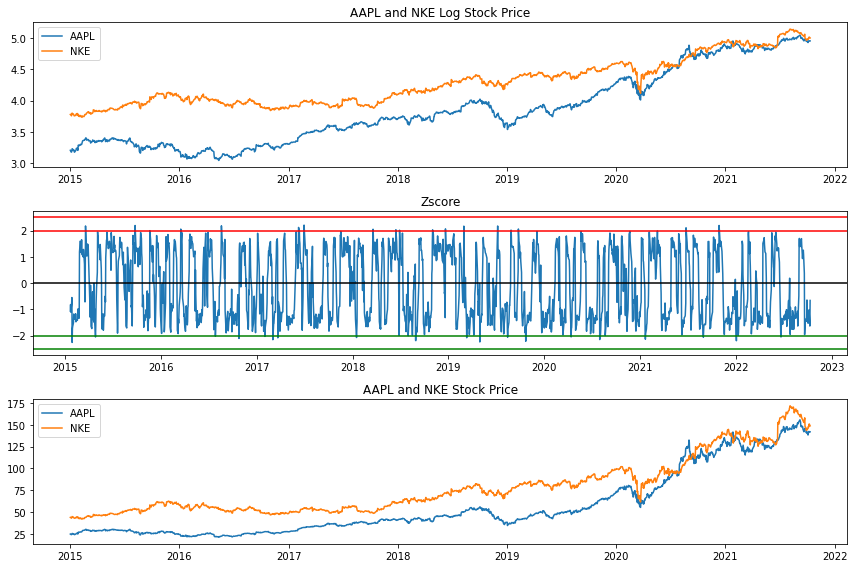

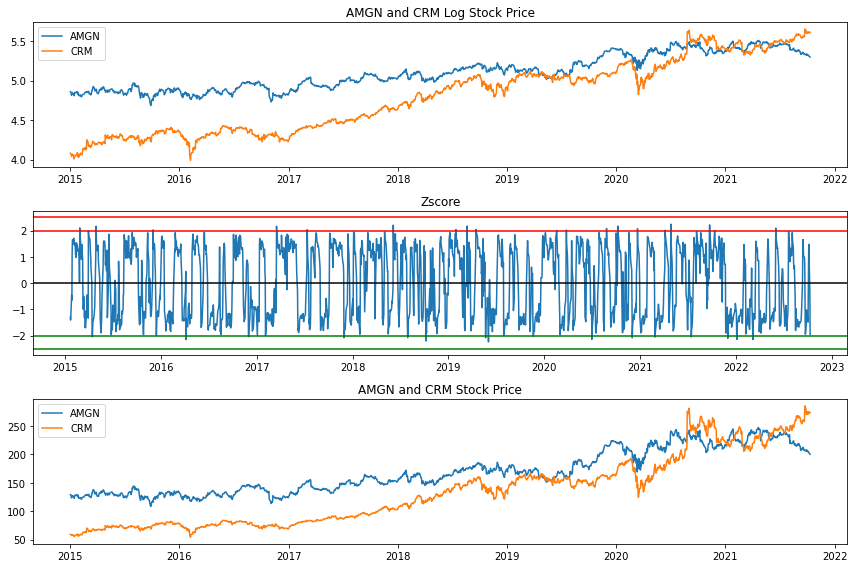

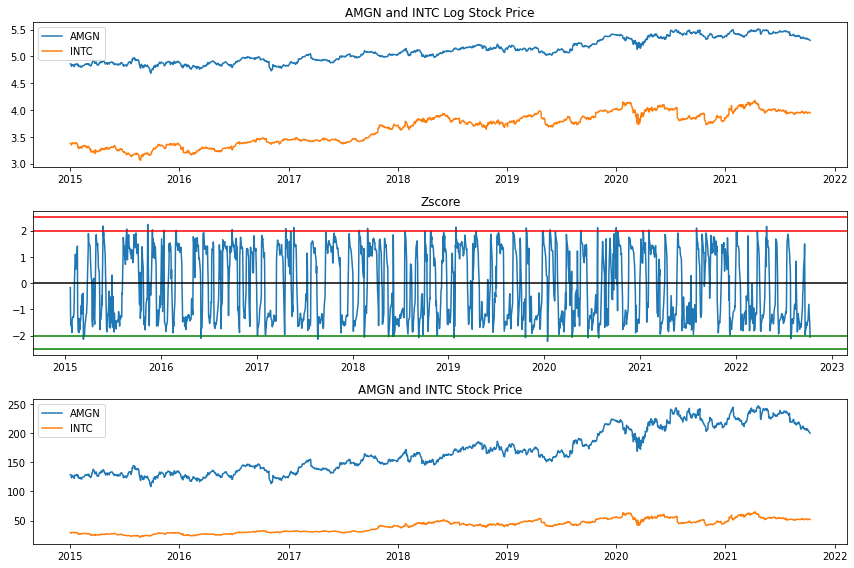

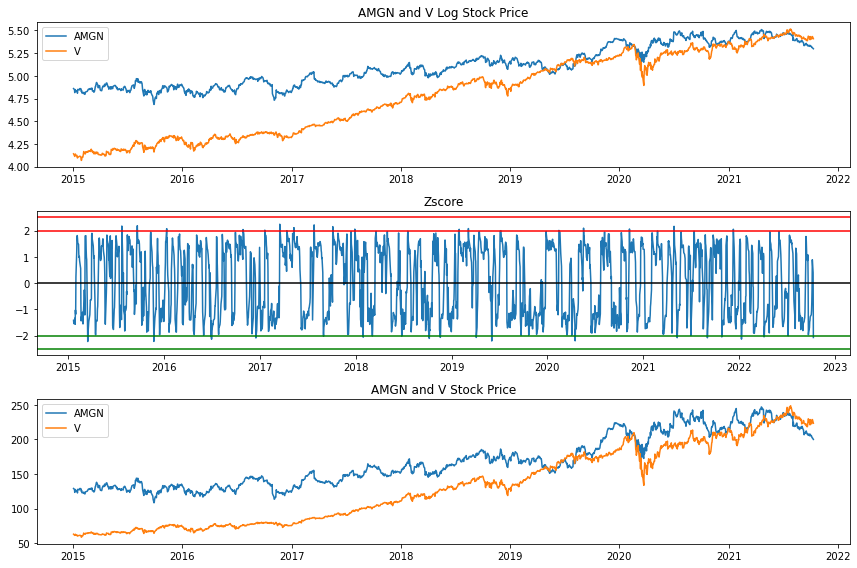

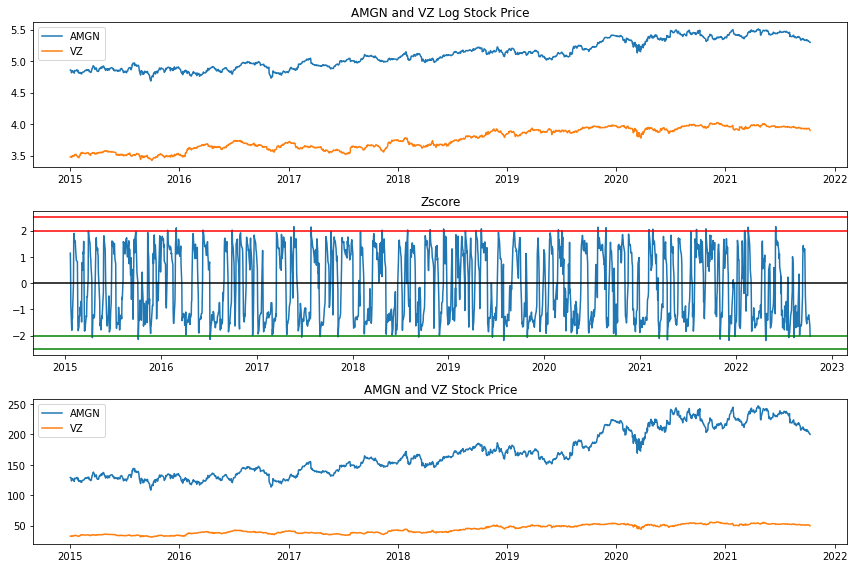

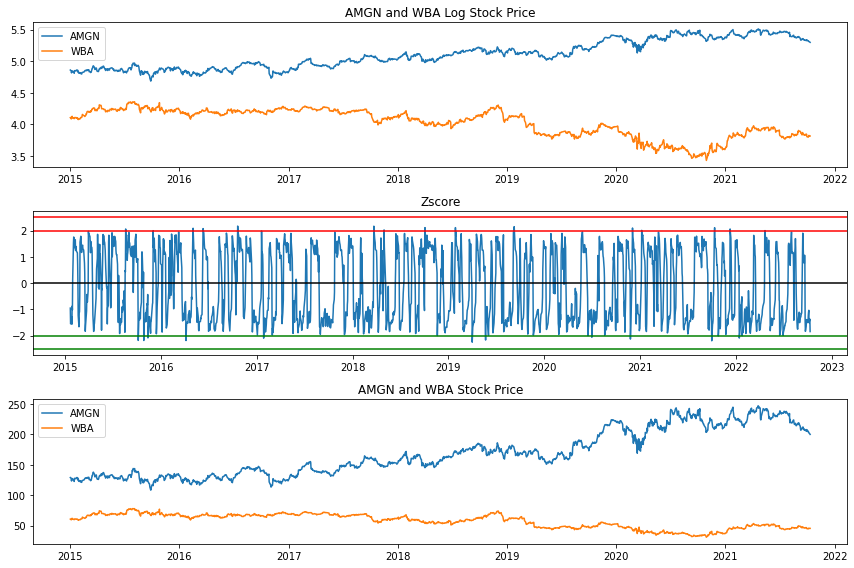

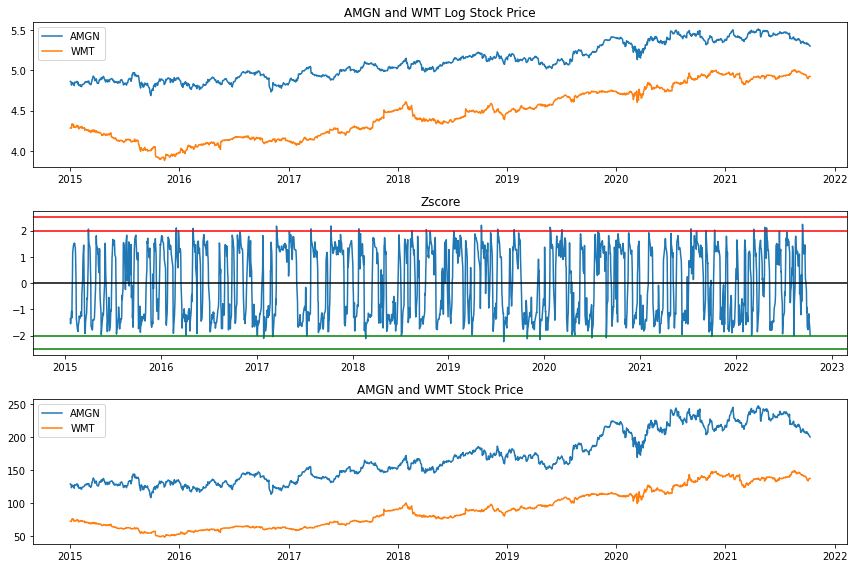

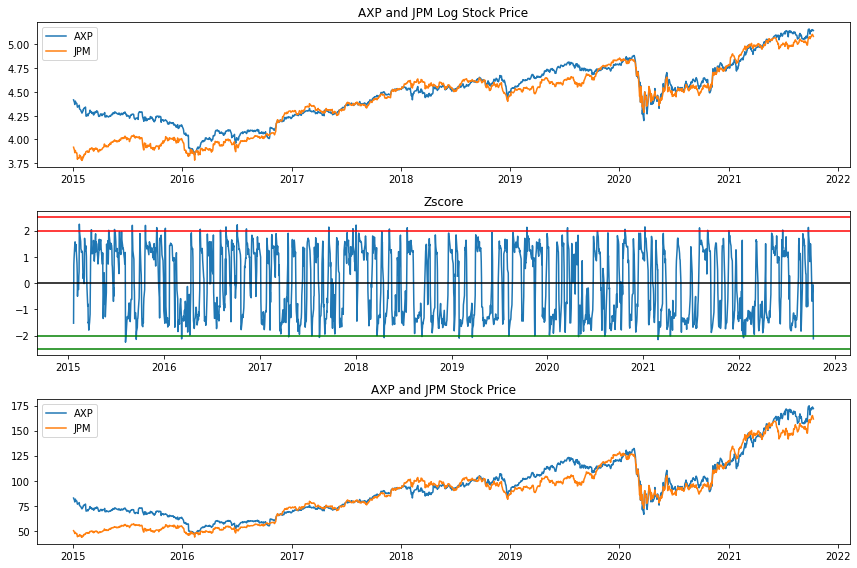

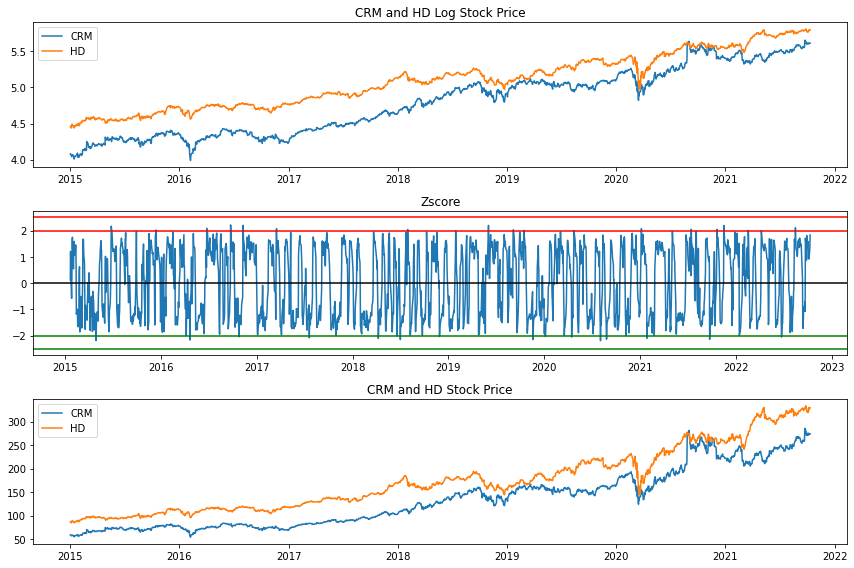

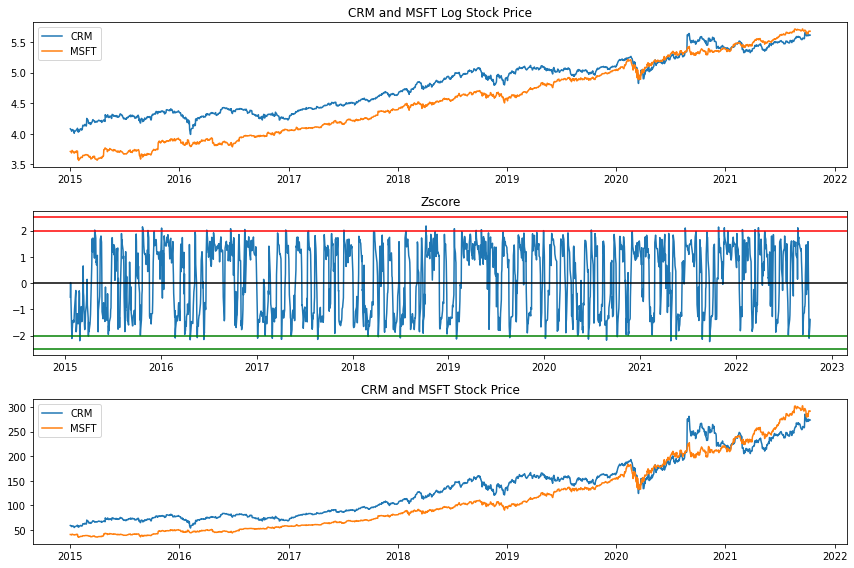

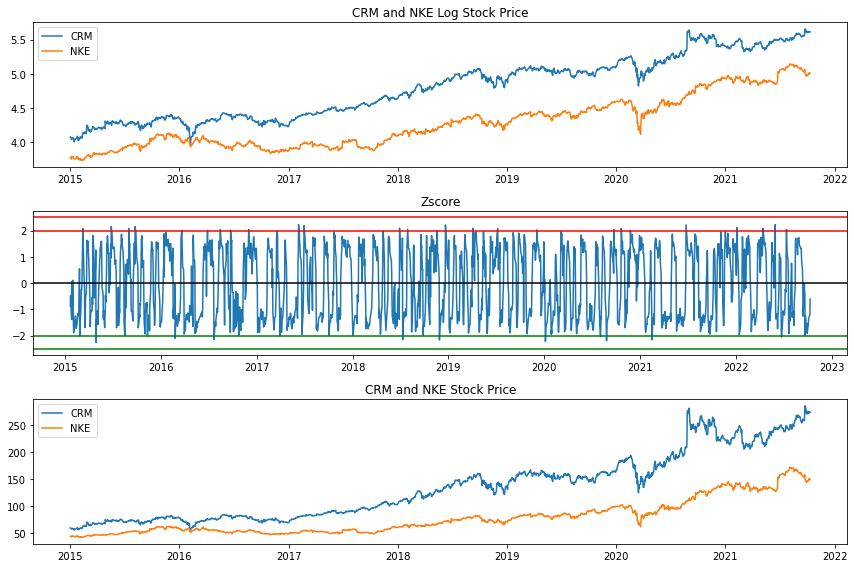

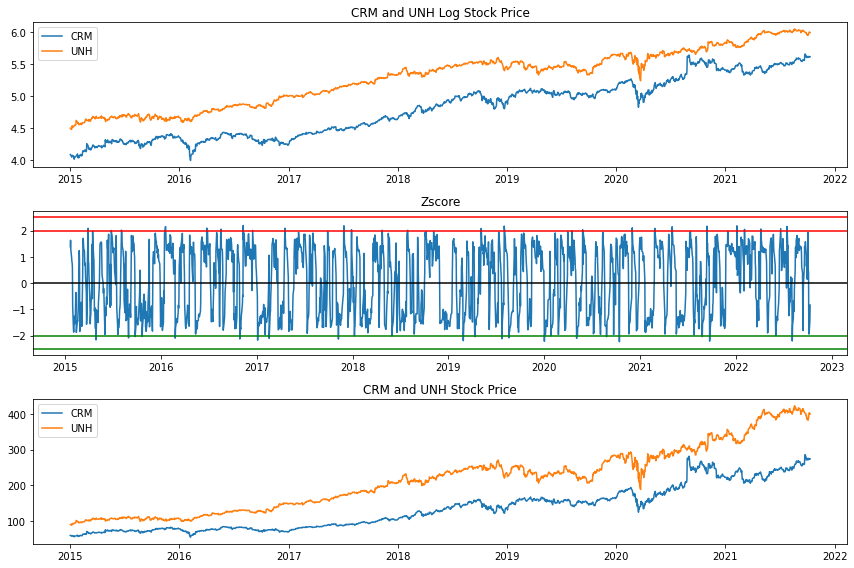

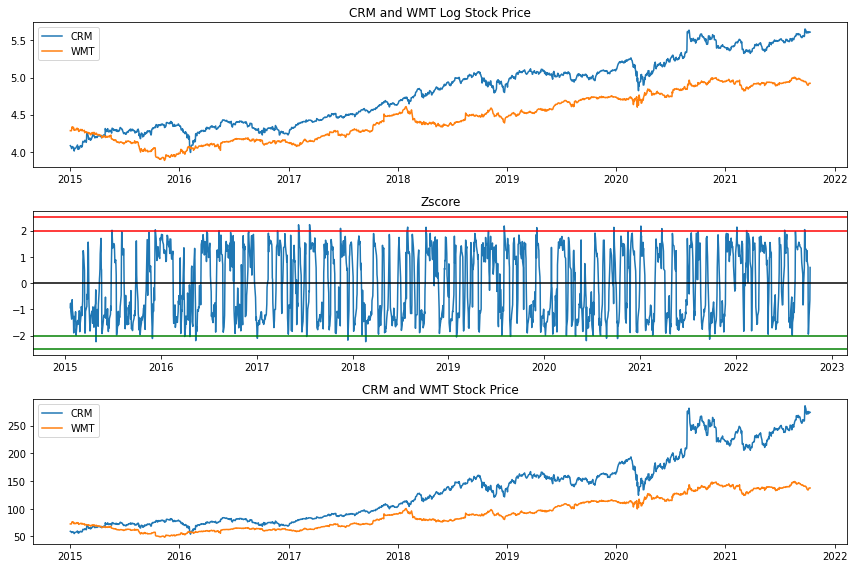

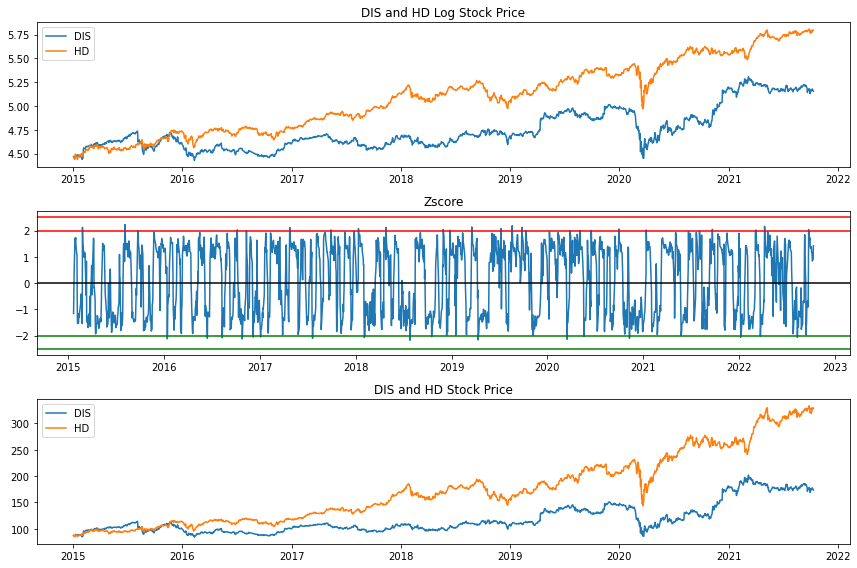

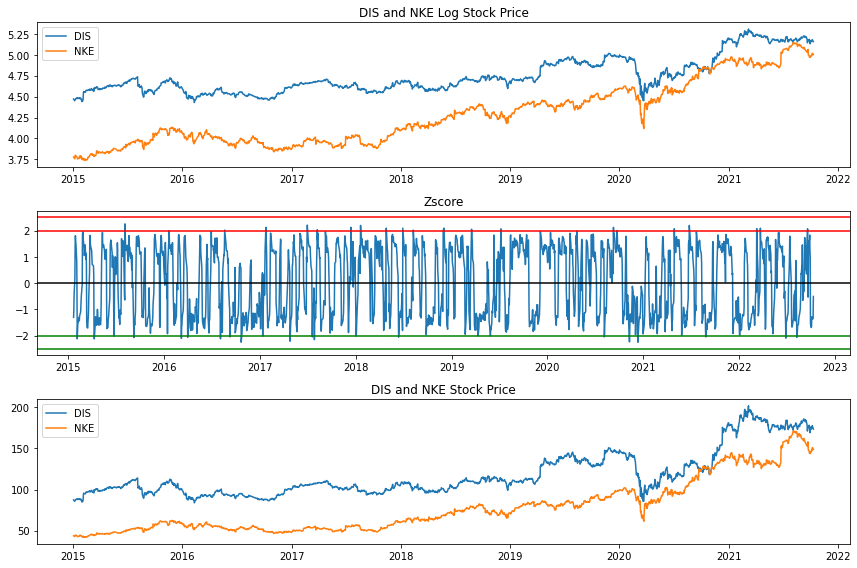

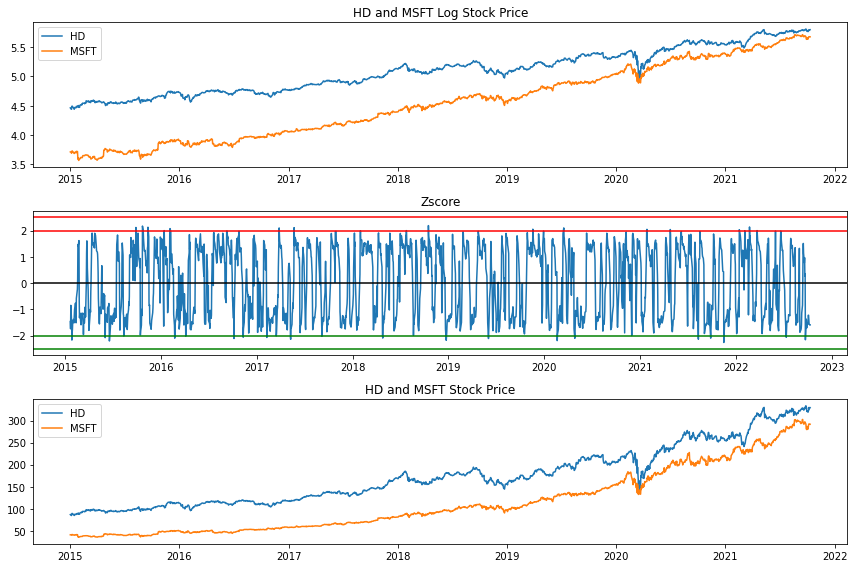

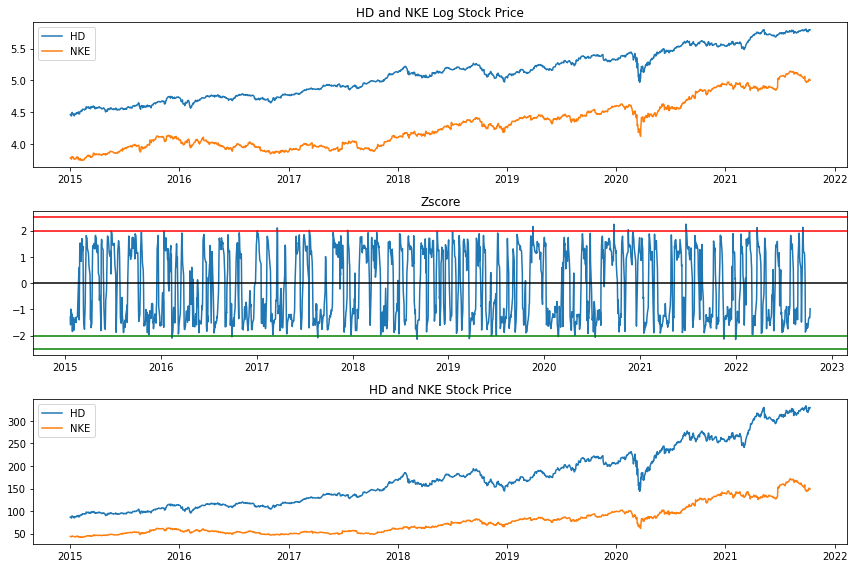

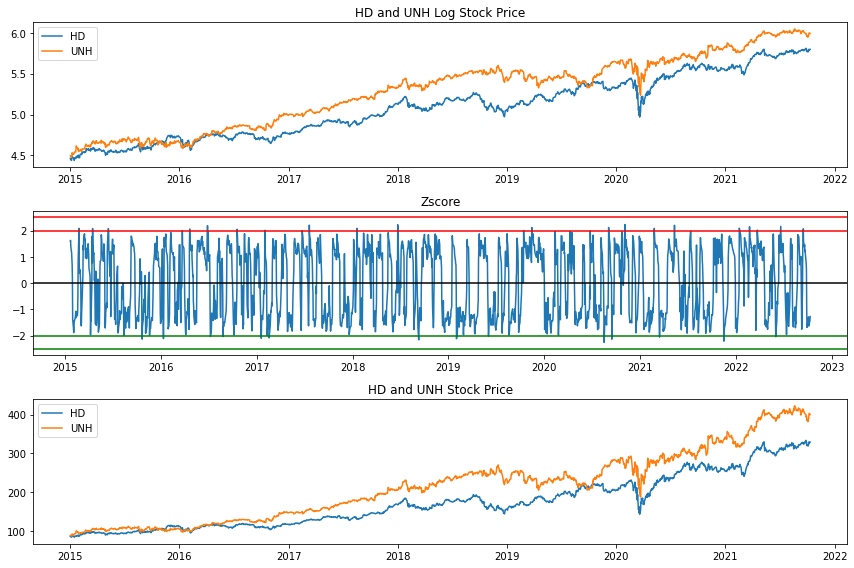

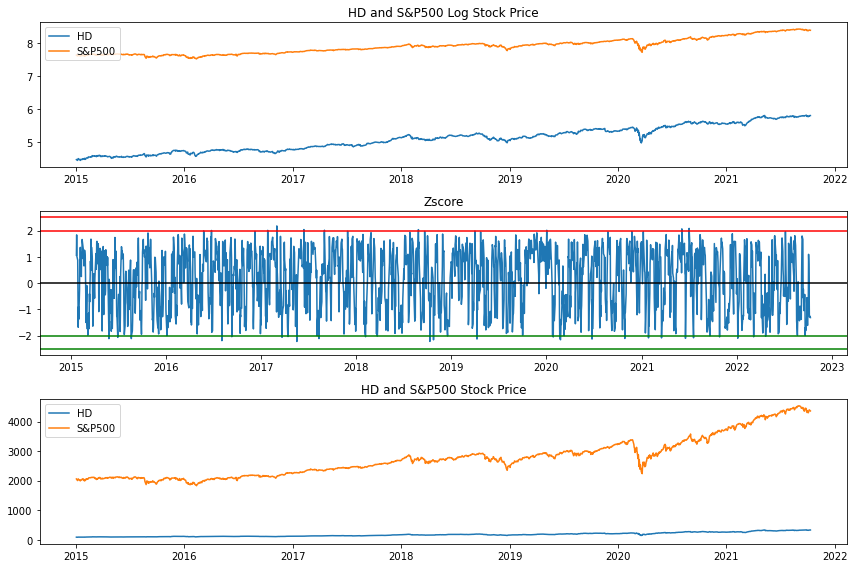

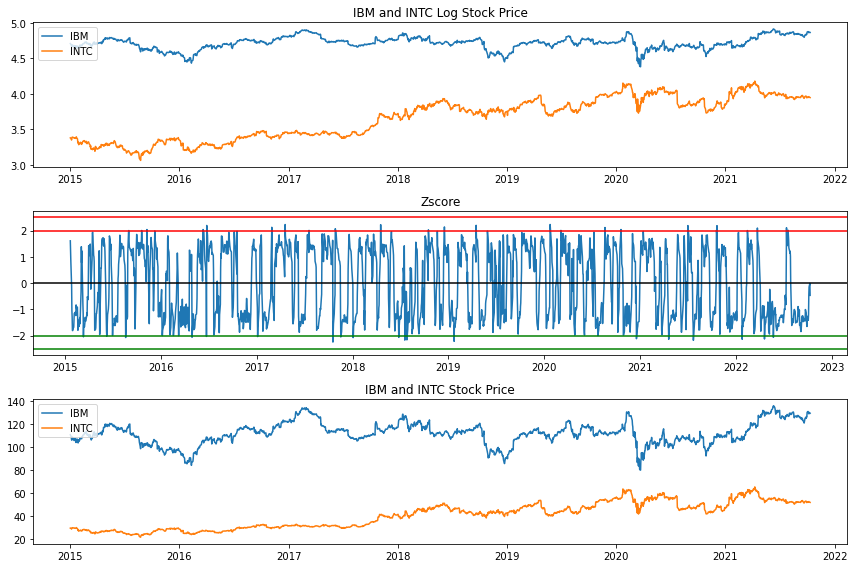

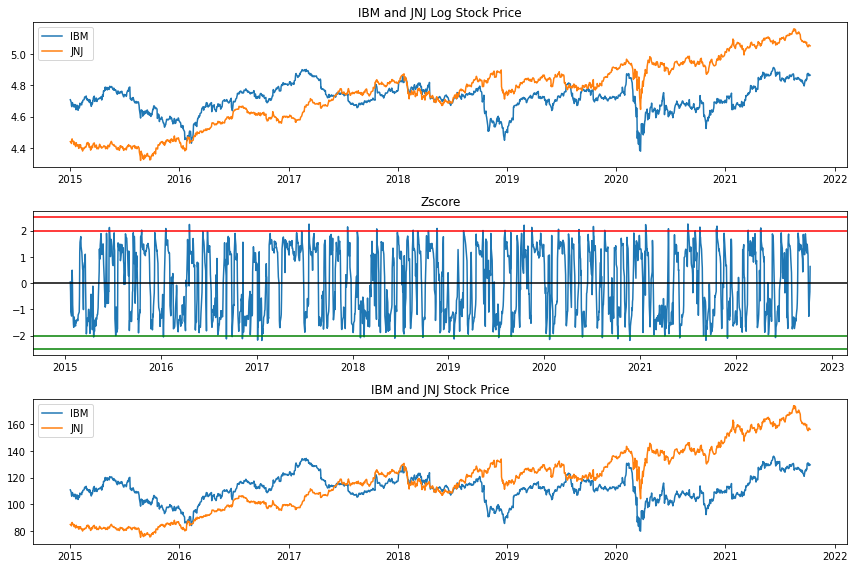

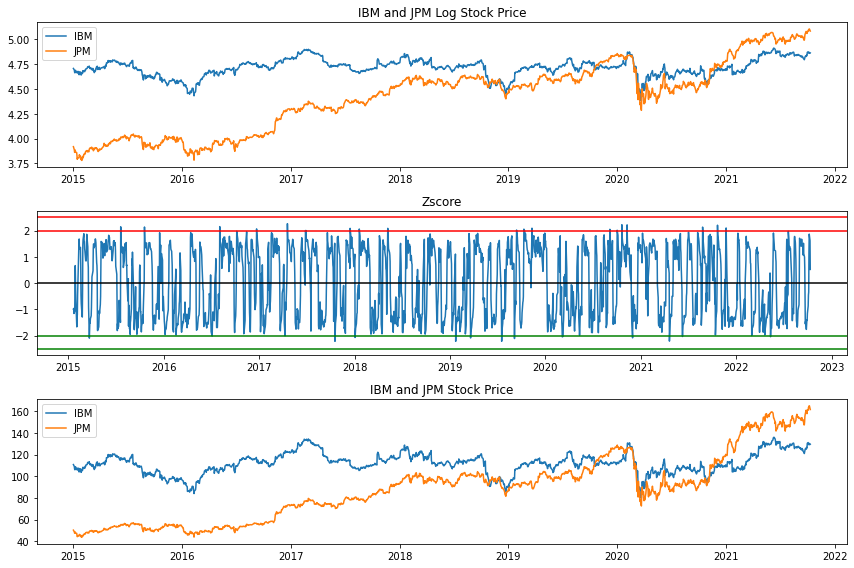

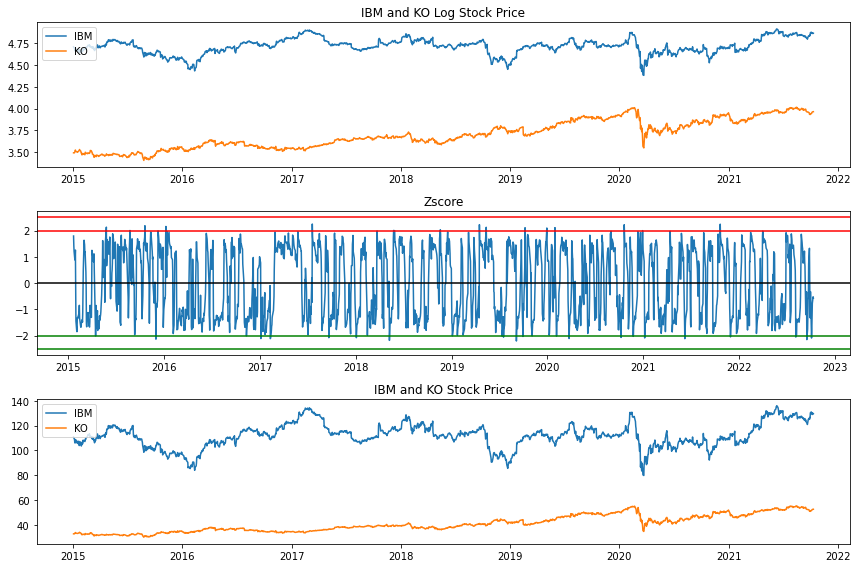

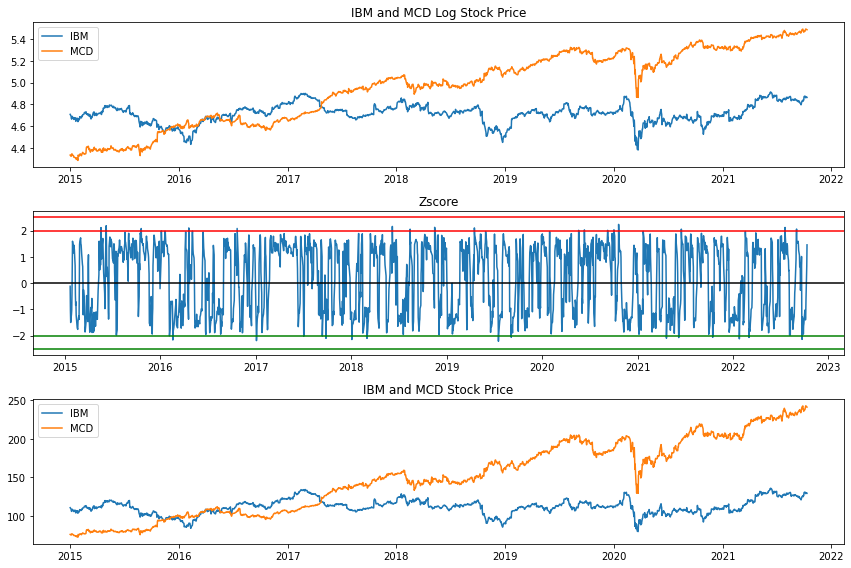

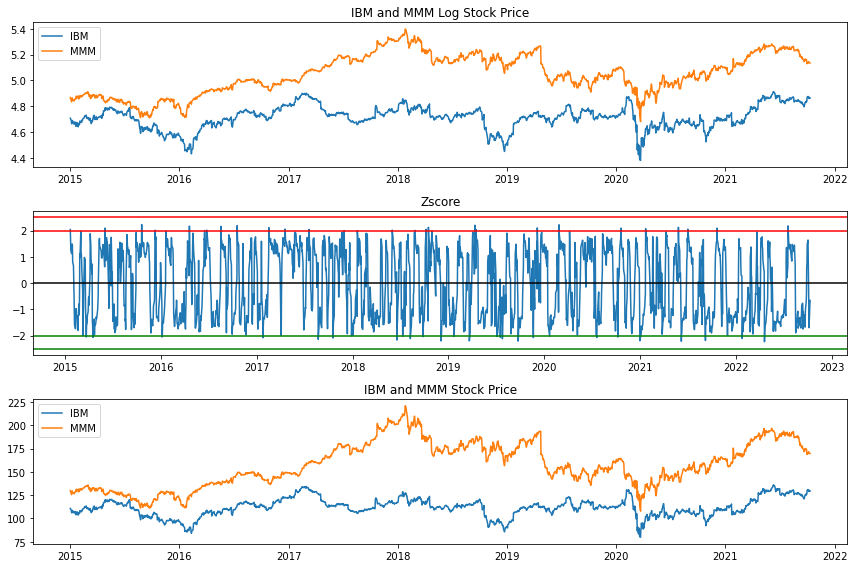

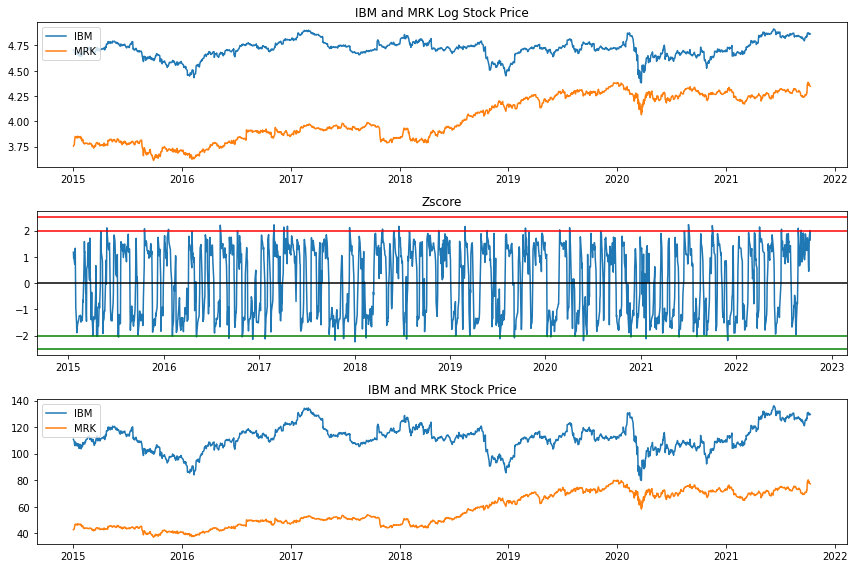

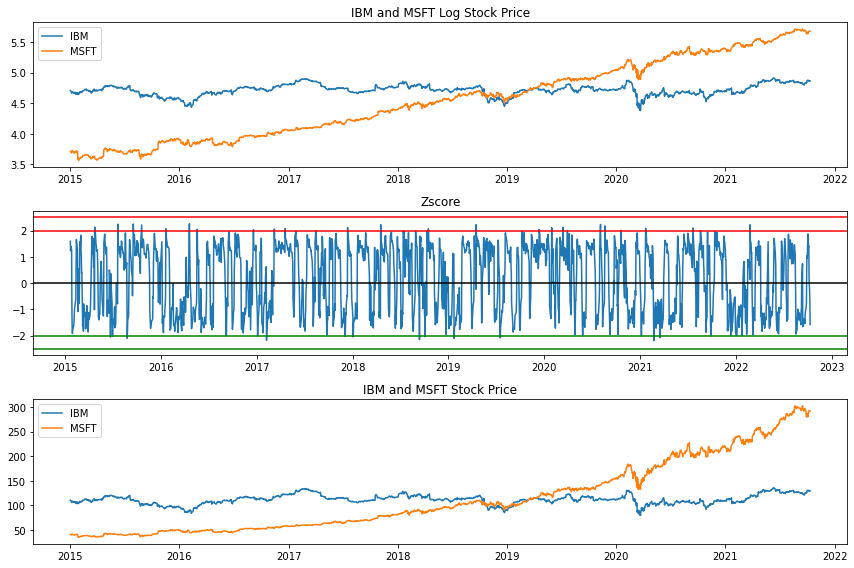

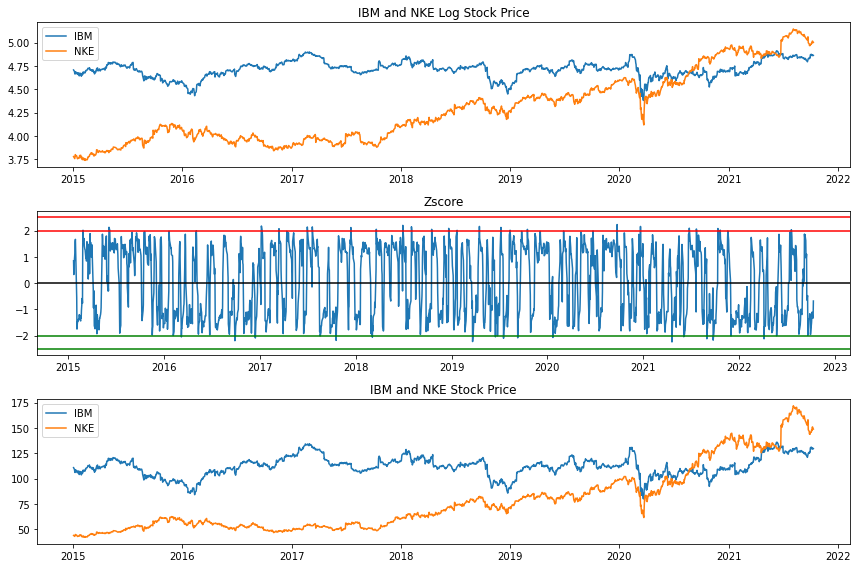

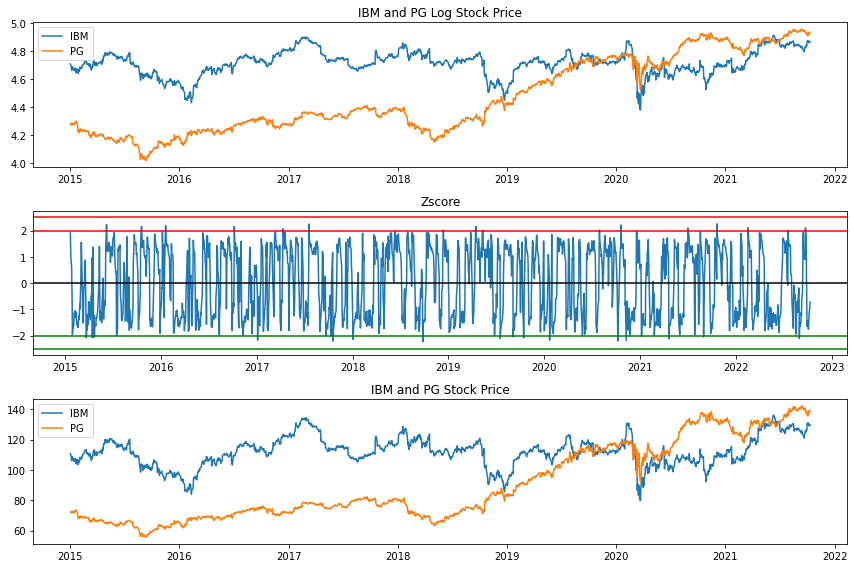

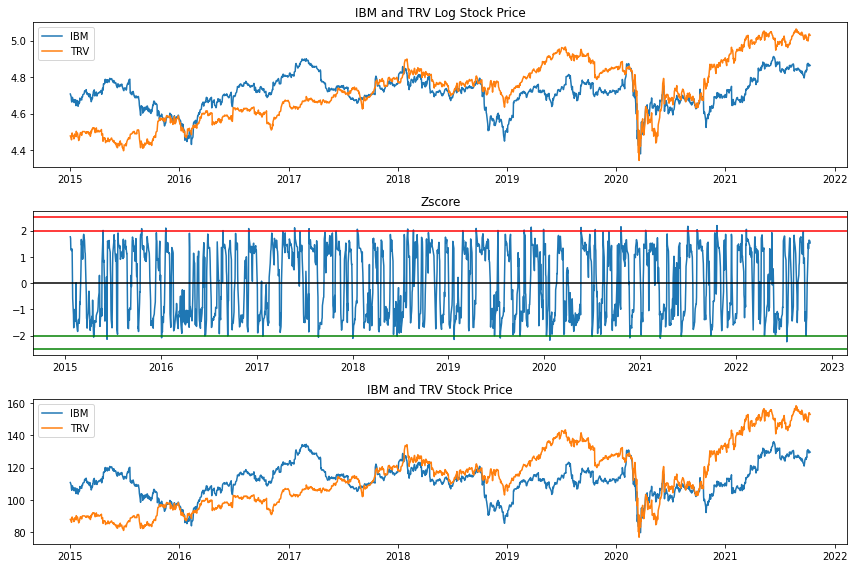

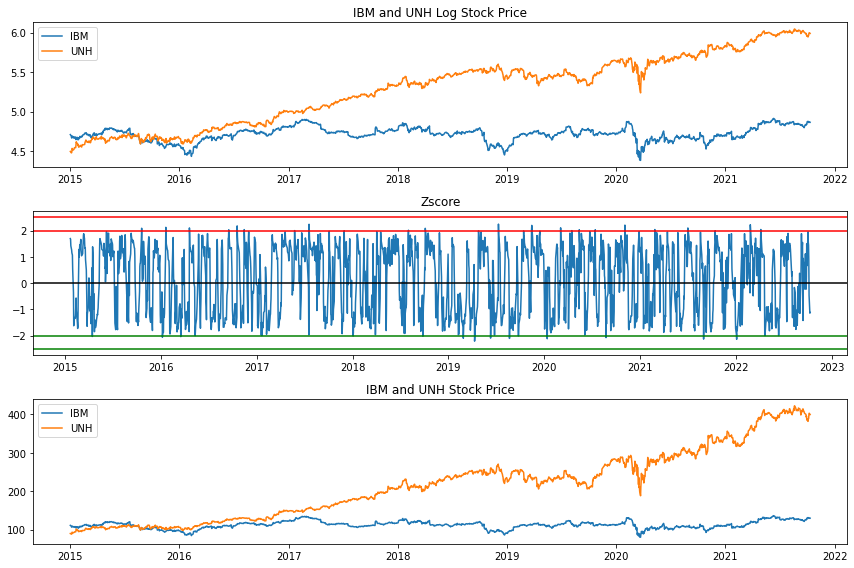

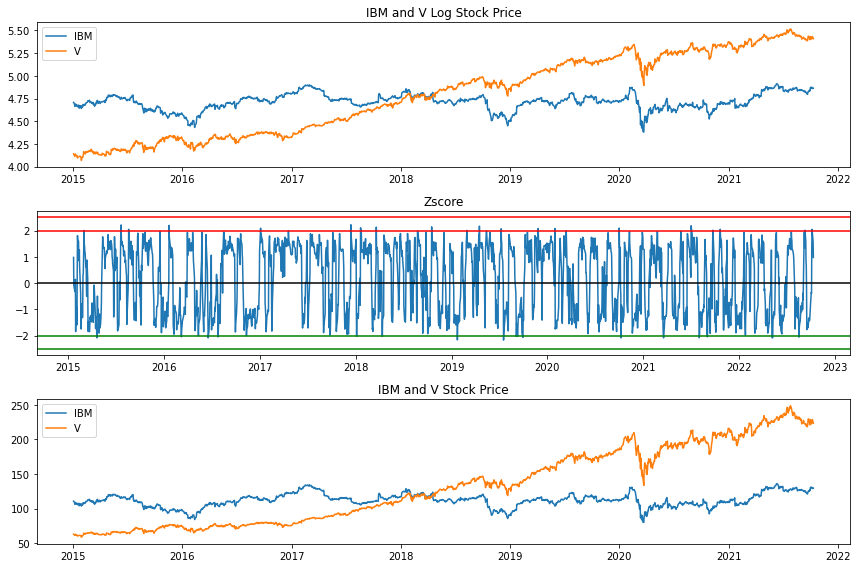

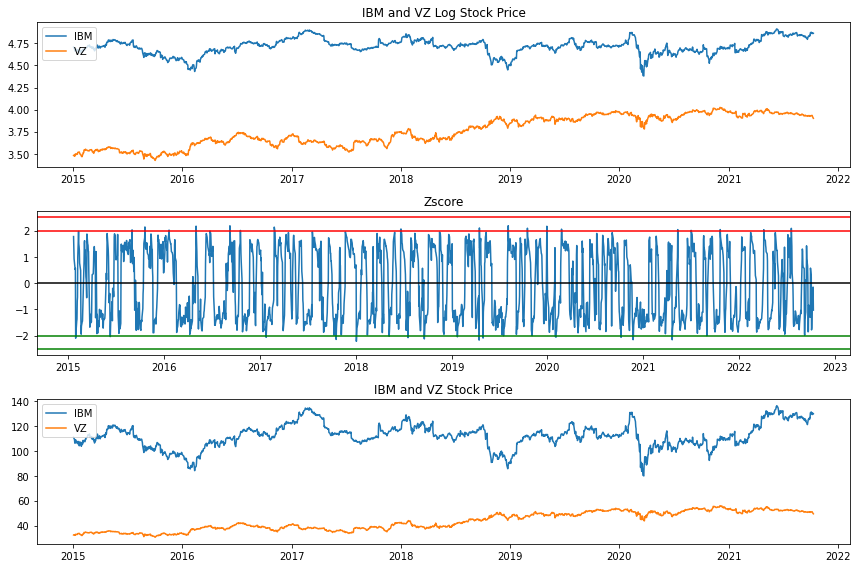

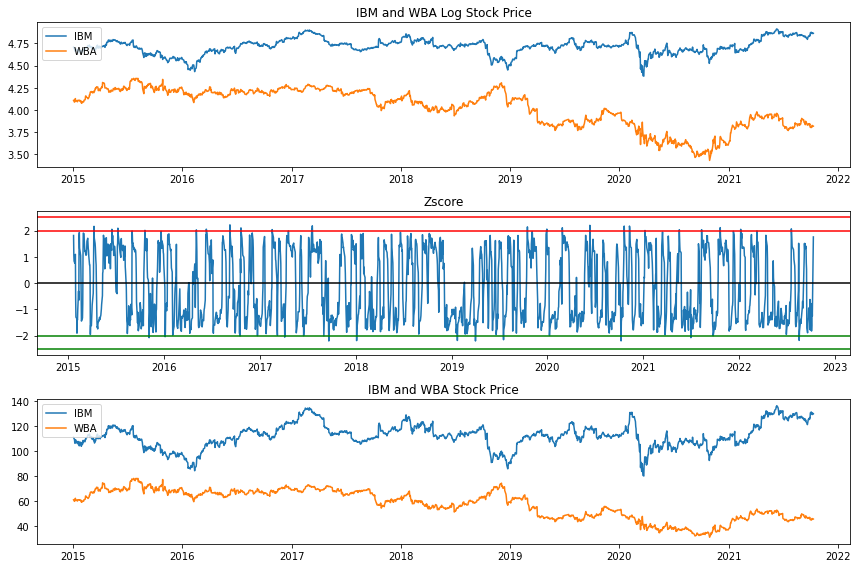

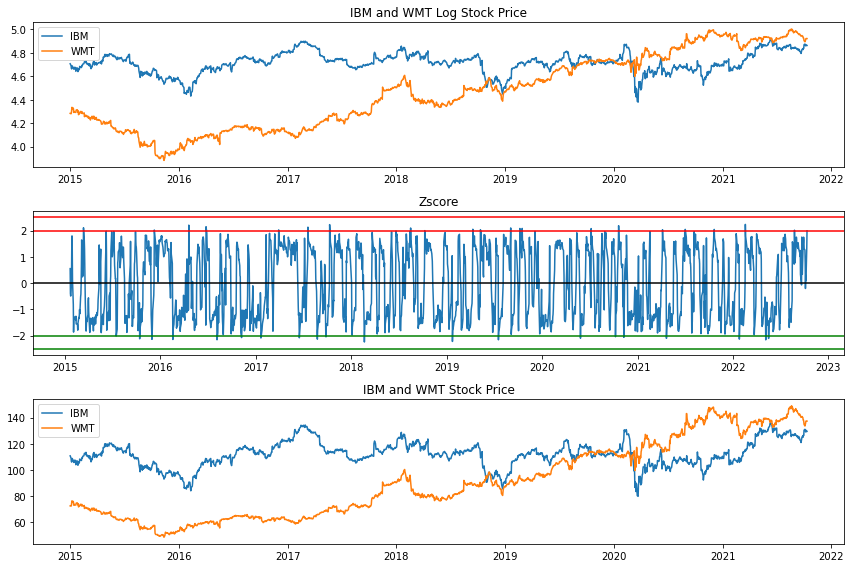

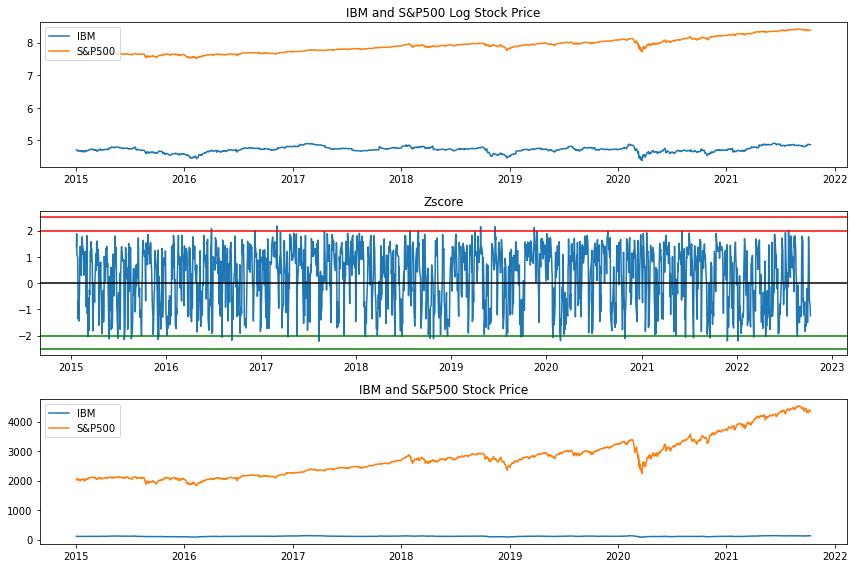

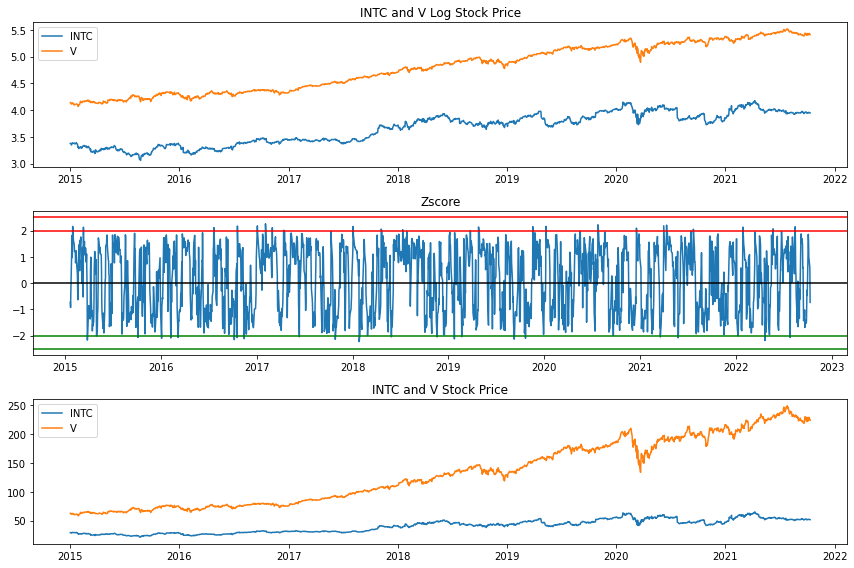

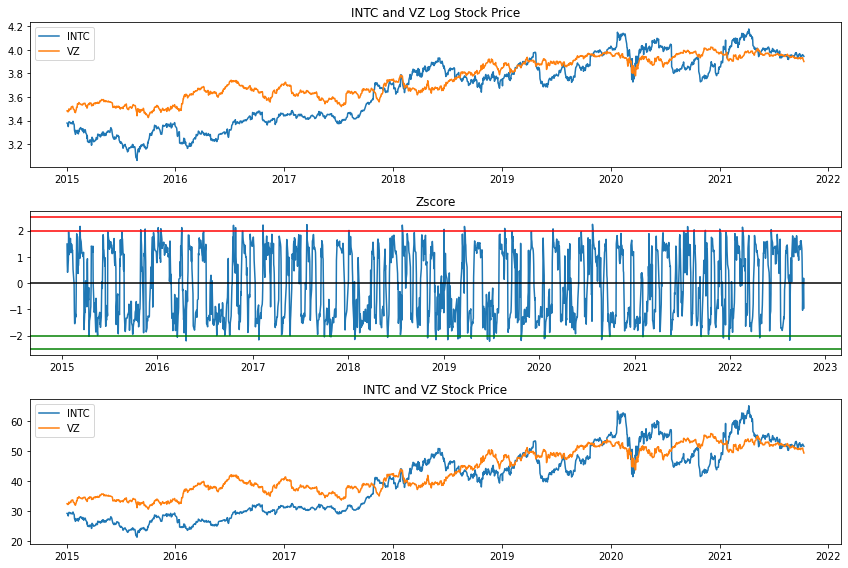

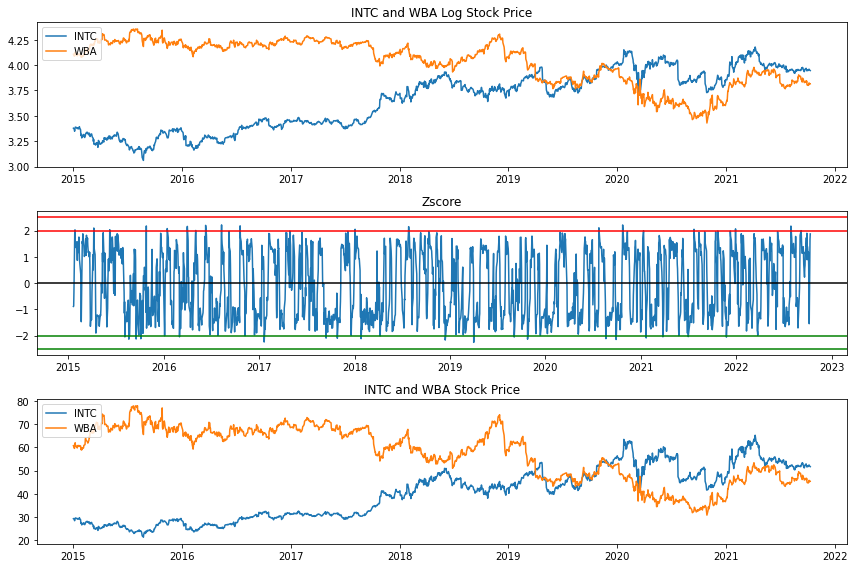

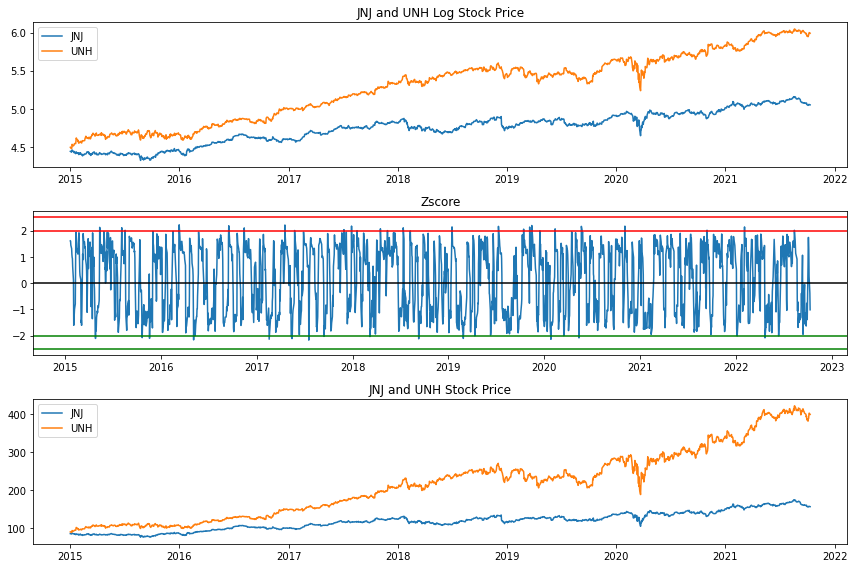

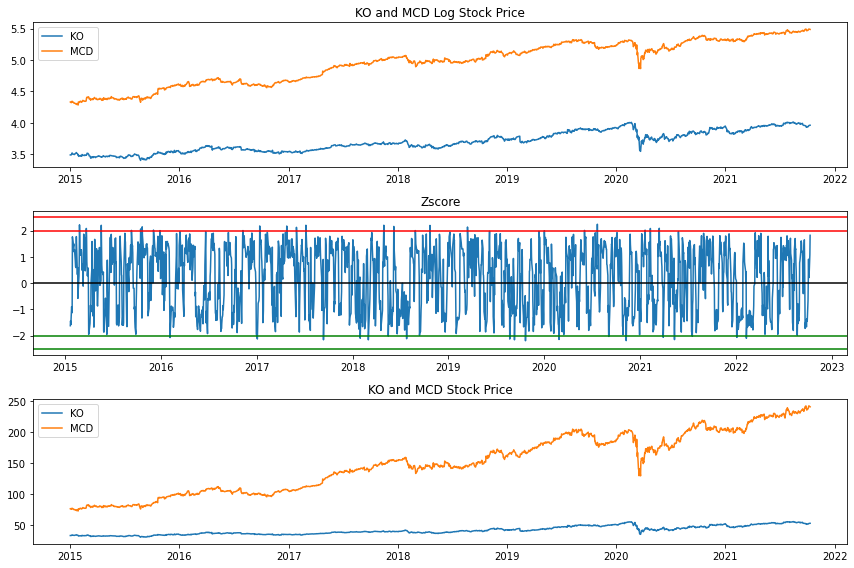

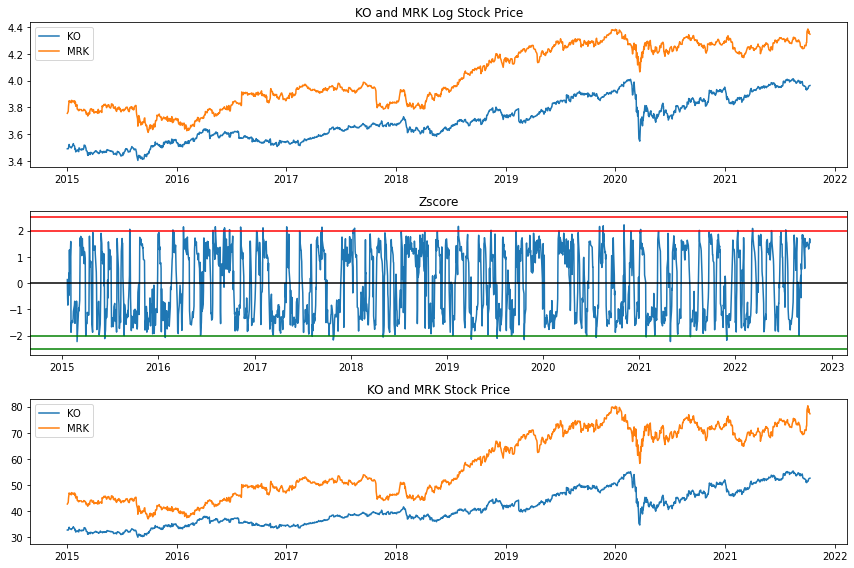

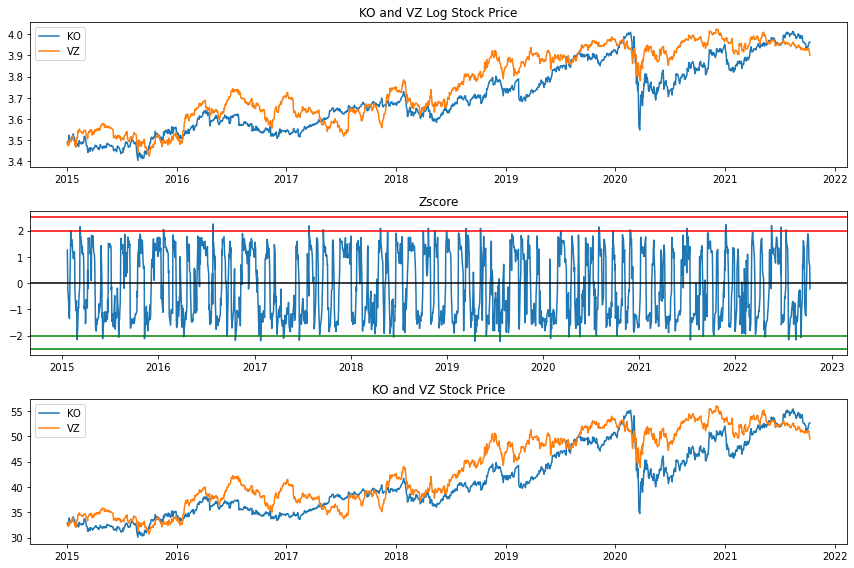

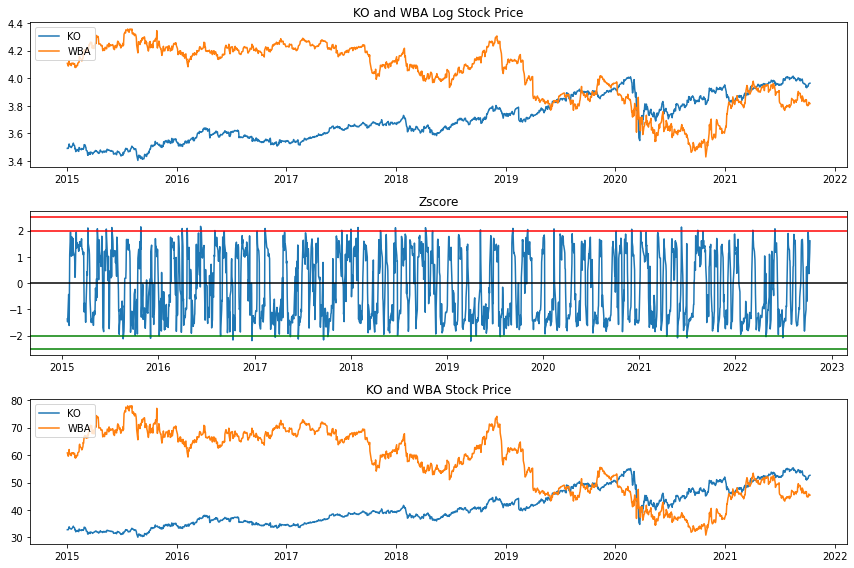

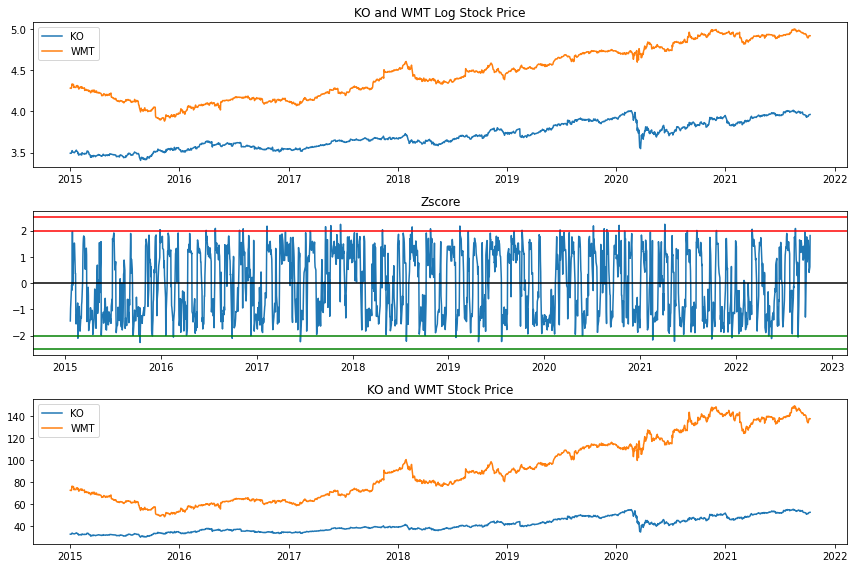

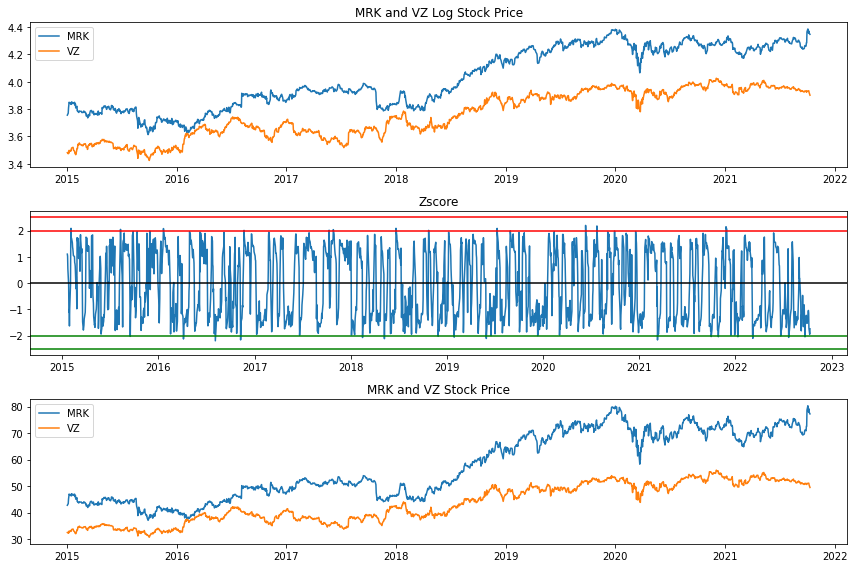

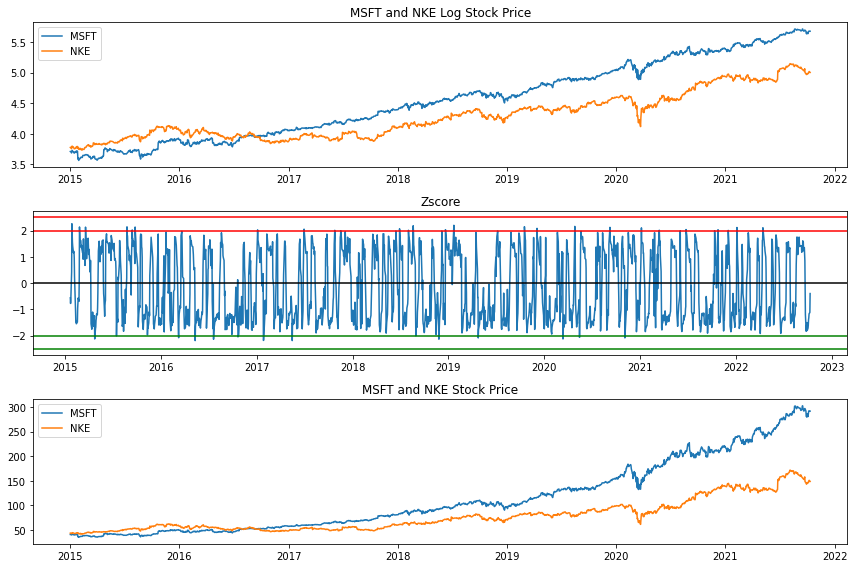

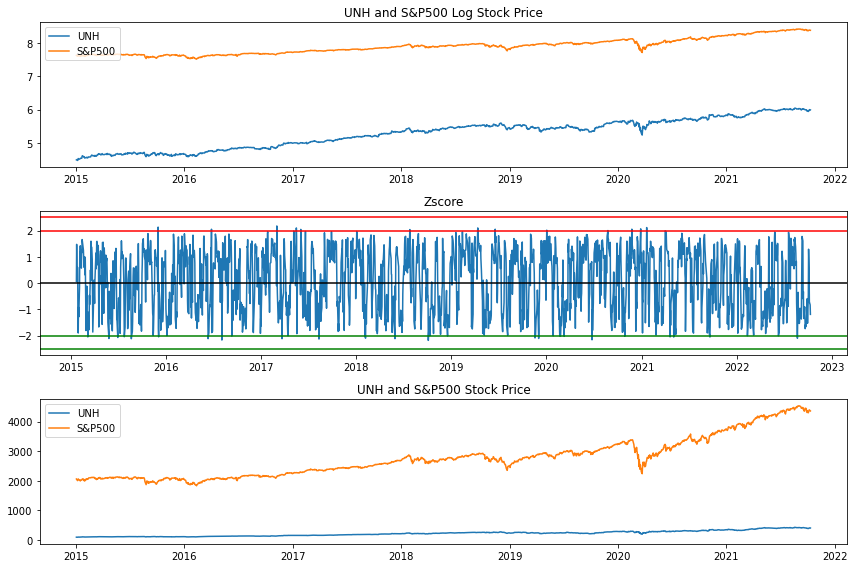

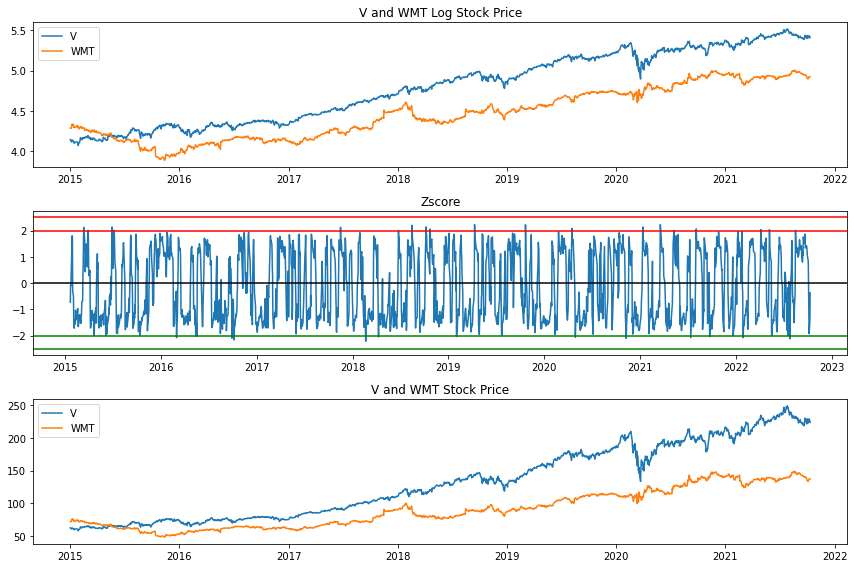

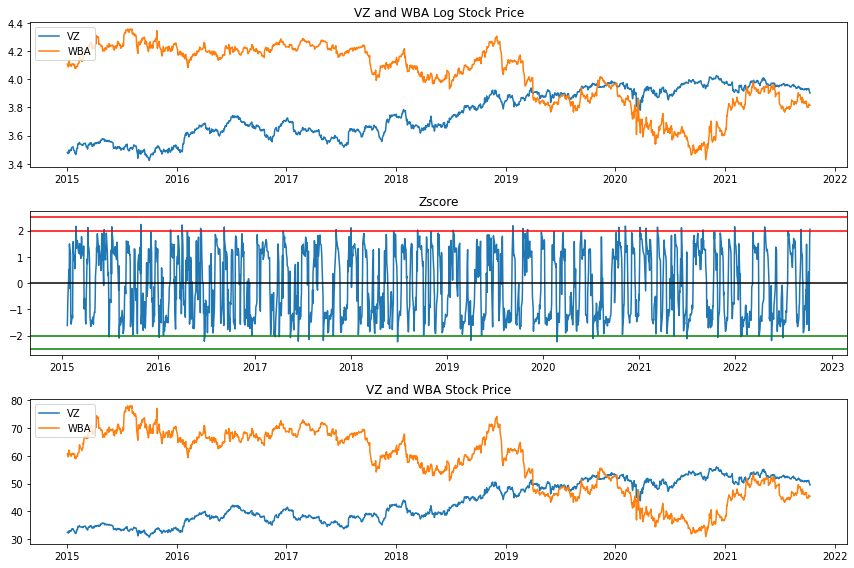

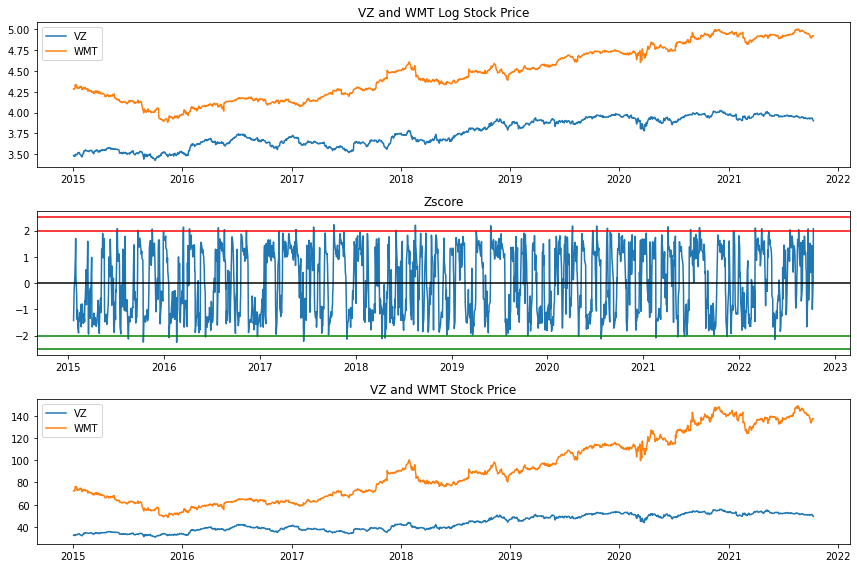

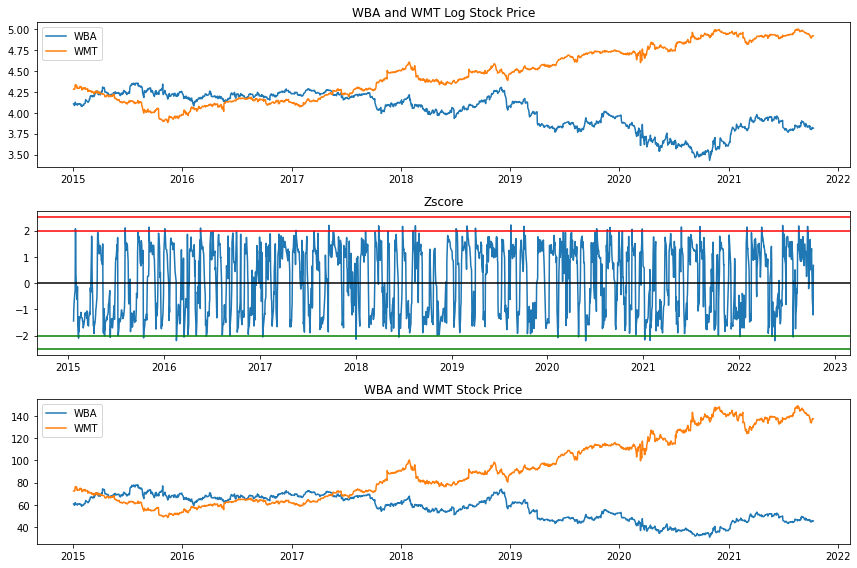

In [14]:
zscores_train = zscores[:-252]
zscores_test = zscores[zscores.shape[0]-252:]

for pair in pairs:
    
    fig, (ax1, ax2, ax3) = plt.subplots(3)
    ax1.set_title(f"{pair[0]} and {pair[1]} Log Stock Price")
    ax1.plot(np.log(train[f"{pair[0]}"]), label=pair[0])
    ax1.plot(np.log(train[f"{pair[1]}"]), label=pair[1])
    ax1.legend(loc='upper left')
    ax2.set_title("Zscore")
    ax2.plot(zscores[f"{pair[0]}-{pair[1]}"])
    ax2.axhline(0, color='black')
    ax2.axhline(2, color='red')
    ax2.axhline(2.5, color='red')
    ax2.axhline(-2, color='green')
    ax2.axhline(-2.5, color='green')
    ax3.set_title(f"{pair[0]} and {pair[1]} Stock Price")
    ax3.plot(train[f"{pair[0]}"], label=pair[0])
    ax3.plot(train[f"{pair[1]}"], label=pair[1])
    ax3.legend(loc='upper left')
    fig.tight_layout()
    plt.plot()


In [15]:
zscores.dropna(axis=0, inplace=True)

In [16]:
zscores

AAPL-NKE  AMGN-CRM  AMGN-INTC    AMGN-V   AMGN-VZ  AMGN-WBA  \
Date                                                                      
2015-01-21 -1.066177 -1.285977  -0.171898 -1.419380  1.140414 -0.950672   
2015-01-22 -0.816733 -1.407294  -1.238710 -1.541021  0.495940 -1.549076   
2015-01-23 -1.104965 -1.258268  -1.623902 -1.467297 -0.835054 -1.524385   
2015-01-26 -0.775856 -0.463312  -1.629186 -1.333332 -1.665737 -1.277226   
2015-01-27 -0.548633 -0.648410  -1.881137 -1.567806 -1.794181 -1.563502   
...              ...       ...        ...       ...       ...       ...   
2022-10-05 -1.175154  0.711463  -0.994895 -0.731487 -1.211493 -1.108263   
2022-10-06 -1.024265  1.475796  -0.807166 -0.211735 -1.209958 -1.034210   
2022-10-07 -1.040945  1.056384  -1.018069  0.887918 -1.319588 -1.507685   
2022-10-10 -1.633115 -0.300834  -1.670344  0.400529 -1.630623 -1.369519   
2022-10-11 -0.659499 -1.947386  -2.057115 -2.069006 -2.020561 -1.843516   

            AMGN-WMT   AXP-JPM    CRM-HD  CRM-MSFT  ...     KO-VZ    KO-WBA  \
Date                                                ...                       
2015-01-21 -1.365084 -1.525442  0.113771 -0.534546  ...  1.256754 -1.361005   
2015-01-22 -1.547259  0.687116  1.206369  0.019006  ...  0.302921 -1.476069   
2015-01-23 -1.407729  0.954789  0.295065 -0.484254  ... -0.289994 -1.259482   
2015-01-26 -1.068408  1.533123 -0.579163 -1.674366  ... -0.711978 -0.432987   
2015-01-27 -1.327592  1.569311  0.244194 -2.106641  ... -1.249531 -0.604458   
...              ...       ...       ...       ...  ...       ...       ...   
2022-10-05 -1.357932 -0.218117  0.928850  0.092032  ...  1.703673  1.784437   
2022-10-06 -1.169234 -0.690368  1.165445 -0.949852  ...  1.388902  1.453711   
2022-10-07 -1.392840 -0.336992  0.919973 -2.097352  ...  0.852219  0.361776   
2022-10-10 -1.756099 -0.065912  1.343223 -1.621225  ...  0.634747  1.166049   
2022-10-11 -1.974040 -2.117876  1.830751 -1.383515  ... -0.219208  1.606609   

              KO-WMT    MRK-VZ  MSFT-NKE  UNH-S&P500     V-WMT    VZ-WBA  \
Date                                                                       
2015-01-21 -1.440135  1.101002 -0.558726    0.060934 -0.727750 -1.615966   
2015-01-22 -0.968072  1.027324 -0.774672    1.473721 -0.077121 -0.980913   
2015-01-23 -0.727388  0.543229 -0.600109    0.591257 -0.109666 -0.586046   
2015-01-26 -0.071313 -0.053890  0.420390    0.593247  0.945112  0.224509   
2015-01-27 -0.271476 -1.114326  2.258320   -1.621461  1.591814  0.521113   
...              ...       ...       ...         ...       ...       ...   
2022-10-05  1.355142 -1.040236 -1.391524    0.928063 -0.153671  0.197539   
2022-10-06  1.226331 -1.141162 -1.312958    0.422750 -1.453399  0.435294   
2022-10-07  0.407939 -1.711939 -1.171248   -0.713478 -1.926087 -1.804648   
2022-10-10  0.613381 -1.946438 -1.115102   -0.829887 -1.445964  1.778628   
2022-10-11  1.808540 -1.739012 -0.397449   -1.190015 -0.373171  2.048094   

              VZ-WMT   WBA-WMT  
Date                            
2015-01-21 -1.425004 -1.440745  
2015-01-22 -0.738395 -0.980871  
2015-01-23 -0.302268 -0.766655  
2015-01-26  0.275818 -0.348044  
2015-01-27  0.643582 -0.332653  
...              ...       ...  
2022-10-05  0.728254  0.528852  
2022-10-06  0.541946  0.195831  
2022-10-07 -0.998496 -0.574561  
2022-10-10  0.077277 -1.209935  
2022-10-11  2.072073  0.674722  

[1946 rows x 52 columns]